# Airports in Scotland

This project seeks understand the direct internal flight routes between airports in Scotland. It asks, which airports are most critical to Scotland's air infrastructure and how the network can be strengthened?

Data was constructed by hand by taking information from each of the airport's public website. For this reason, minimal data cleaning is required before starting analysis.

Note: Data from Oban Airport to Coll and Colonsay has been left out of the dataset.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import list of nodes
airports = pd.read_csv("Data/ListOfAirportsAndAirfields.csv")
airports.head()

,id,airport,latitude,longitude
0,0,Aberdeen International Airport,57.2037,-2.2005
1,1,Edinburgh Airport,55.9474,-3.3614
2,2,Glasgow Airport,55.8699,-4.4326
3,3,Glasgow Prestwick Airport,55.5112,-4.5911
4,4,Oban Airport,56.4655,-5.3983


In [2]:
# import list of edges
edges = pd.read_csv("Data/FlightRoutes.csv")
edges.head()

,departure,destination
0,0,11
1,0,13
2,0,15
3,1,13
4,1,12


## Data cleaning and formatting

In [3]:
airports.dtypes

id             int64
airport       object
latitude     float64
longitude    float64
dtype: object

Checking the data types, we can see that the airport ID has been stored as an integer, and the airport name has been stored as an object - this is appropriate since we can consider the airports as categorical values rather than as strings. However, let's confirm the airports are stored as categorical data using `astype("category")`. The latitude and longitude of the airports have also been correctly loaded into pandas as floats.

In [4]:
airports["airport"] = airports["airport"].astype("category")

Now let's check the data types of the edges between nodes. This represents the flight routes.

In [5]:
edges.dtypes

departure      int64
destination    int64
dtype: object

The departure and destination airports are represented by the airport IDs and have been (appropriately) imported as integers. Later when the map is being plotted, we will have to convert from the numerical identifiers to airport names.

## Visualising the air network in Scotland

First, let's generate a network to show the connections between different airports in Scotland. This will help us understand the possible flight routes within the country.

In [6]:
# create graph
G = nx.Graph()
for i, node in airports.iterrows():
    G.add_node(node["id"], pos=(node["longitude"], node["latitude"]))

# add edges to graph
for i, edge in edges.iterrows():
    G.add_edge(edge["departure"], edge["destination"])

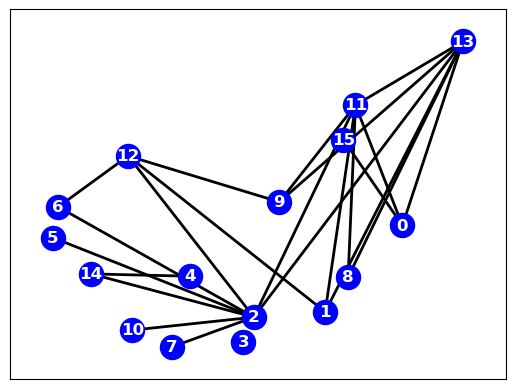

In [7]:
# draw the network
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="blue", alpha=1)
nx.draw_networkx_labels(G, pos, font_color="white", font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="black", width=2, arrows=False)

Here we can see the network has been plotted accurately, with latitude and longitude between the different airports being accurately represented.

Additionally, notice that node 3 (Glasgow Prestwick) is an isolate - it has no flight connections to any other airport in Scotland. This is because Prestwick serves short-haul international destinations to mainland Europe. Because of this, Glasgow Airport is responsible for air connections within the country.

Now the network connections have been graphed, let's see this plotted on a map of Scotland to improve clarity and understanding.

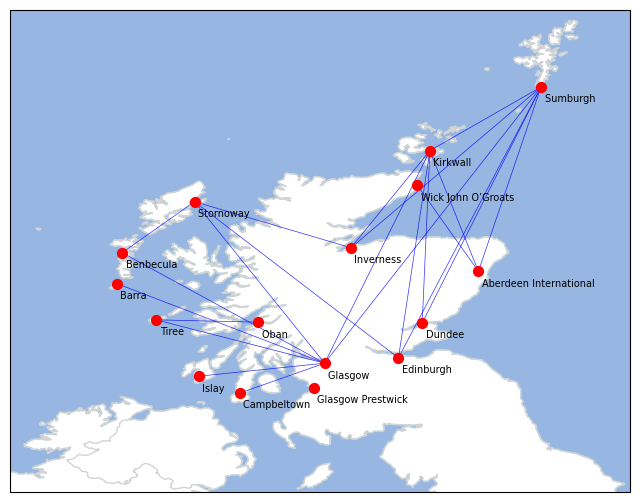

In [8]:
# plot map with points, connections, and the names of the airports
mapProjection = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection=mapProjection)
ax.set_extent([-9, 0, 54, 61], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor="lightgrey")
ax.add_feature(cfeature.BORDERS, edgecolor="lightgrey")
ax.add_feature(cfeature.OCEAN, edgecolor="lightblue")
#ax.gridlines()

ax.scatter(x=airports.longitude, y=airports.latitude, color="red", s=50, alpha=1, zorder=3,transform=ccrs.PlateCarree())

# plot labels
for _, row in airports.iterrows():
    ax.text(
        row["longitude"] + 0.05,
        row["latitude"] - 0.25,
        row["airport"].replace("Airport", ""), # remove word "Airport" at the end of each line for image clarity
        transform=ccrs.PlateCarree(),
        fontsize=7,
        ha="left",
        va="bottom",
        zorder=4
    )


# plot connections
for u, v in G.edges():
    lon1, lat1 = pos[u]
    lon2, lat2 = pos[v]

    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        color="blue",
        linewidth=0.5,
        alpha=0.8,
        transform=ccrs.Geodetic(),
        zorder=2
    )

## Which airports are most critical for Scotland's air infrastructure?
Centrality statistics can be used to measure each node's (airport's) importance in the network:
- Degree centrality tells us the number of direct connections each airport has. This can inform us about which airports are locally most significant.

- Closeness centrality tells us how efficiently a node can reach every other node. This tells us which airports can reach other airports in the fewest number of flights. This is perhaps not too useful in country the size of Scotland, since individuals may opt to travel by car or train to reach locations most efficiently. However, it could indicate good points to station emergency air services or mail couriers, because all other locations can be quickly accessed.

- Betweenness centrality tells us how often an airport lies on the shortest path (the shortest route) between other airports. Thus, this statistic can identify the most important hubs, as well as bottlenecks where too many routes pass through one airport. This may be important in a Scottish context, since some islands are quite isolated and the primary route from these islands to major population centre may go through another airport. In the case that there is a disruption at one of these hubs, it could affect flight routes across the whole country - indicating a weakness in the air infrastructure.

Let's create a table showing the degree, closeness, and betweenness centrality scores for the different airports in Scotland.

In [9]:
airportNames = airports.airport
degreeCentrality = [i for i in nx.degree_centrality(G).values()]
closenessCentrality = [i for i in nx.closeness_centrality(G).values()]
betweennessCentrality = [i for i in nx.betweenness_centrality(G).values()]

data = {"airport":airportNames,
        "degreeCentrality":degreeCentrality,
        "closenessCentrality":closenessCentrality,
        "betweenessCentrality":betweennessCentrality}

centrality = pd.DataFrame(data=data)

centrality

,airport,degreeCentrality,closenessCentrality,betweenessCentrality
0,Aberdeen International Airport,0.200000,0.395960,0.123810
1,Edinburgh Airport,0.200000,0.408333,0.015873
2,Glasgow Airport,0.533333,0.622222,0.577778
3,Glasgow Prestwick Airport,0.000000,0.000000,0.000000
4,Oban Airport,0.066667,0.290370,0.000000
5,Barra Airport,0.066667,0.384314,0.000000
6,Benbecula Airport,0.133333,0.421505,0.000000
7,Campbeltown Airport,0.066667,0.384314,0.000000
8,Dundee Airport,0.133333,0.373333,0.000000
9,Inverness Airport,0.200000,0.408333,0.015873


Here we can see that the airports with the greatest degree centrality are Glasgow Airport (0.53), Kirkwall Airport (0.40), and Sumburgh Airport (0.40). We can see on the map that these airports do ideed have the most direct connections to other airports, meaning they are locally quite important in connecting their region.

We can also see that several airports have a high closeness centrality including Glasgow Airport (0.62), Kirkwall (0.57), and Sumburgh (0.57). These three airports have the best access to other airports in the network, indicating that critical services could be based at these locations.

Finally, we can see that the airport with by far the greatest betweenness centrality is Glasgow (0.58). Many routes must travel through this airport. This means Glasgow Airport is structurally the most critical point in Scotland's airport infrastructure.

If trying to travel, for instance, between Oban Airport and Campbeltown Airport you would have to pass through Glasgow Airport. Since there is currently no alternative route, a disruption at Glasgow Airport could affect the whole country's air network. For this reason, it would make sense to direct some flights through another airport, for example Edinburgh, Dundee or Inverness, which have comparatively low betweenness centralities (0.02, 0.00 and 0.02 respectively). This is known as increasing redundancy, and would make the whole network more resilient.

Making such changes may be quite costly, since airports would have to prepare for a higher amount of air traffic. It is up to regional planners to decide whether to strengthen local infrastructure though improved flight routes or by other means, like regular boat services between islands and more train services on the mainland.